In [1]:
import os
from os.path import join
import sys
sys.path.append("../")

from DataAnalyzer import DataAnalyzer
from time import perf_counter

DATA_ROOT = "/home/guest/work/Datasets"

paths = {
    "picai_labels_wg" : "picai_labels_all/picai_labels-main/anatomical_delineations/whole_gland/AI/Guerbet23",
    "picai_labels_zonal" : "picai_labels_all/picai_labels-main/anatomical_delineations/zonal_pz_tz/AI/Yuan23",
    "picai_folds" : "picai_folds/"
}

analyzer = DataAnalyzer(DATA_ROOT)


> Every patient case will at least have three imaging sequences: axial T2W, axial DWI and axial ADC scans (i.e. files ending in _t2w.mha, _hbv.mha, _adc.mha). Additionally, they can also have either, both or none of these optional imaging sequences: sagittal and coronal T2W scans (i.e. files ending in _sag.mha, _cor.mha here). 

Vemos que algunos pacientes tienen imágenes adicionales

In [2]:
# pth = os.path.join(paths["picai_folds"])
# folds = analyzer.get_dirs(pth)

# for fold in folds:
#     rel = os.path.join(pth, fold)
#     dirs = analyzer.get_dirs(rel)
#     incomplete_dirs = []
    
#     for dir in dirs:
#         # check if they all have 5 files
#         rel2 = os.path.join(rel, dir)
        
#         files = analyzer.get_files(rel2)
        
#         if len(list(files)) != 5:
#             print(f"Directory {dir} has {len(list(files))} files, expected 5.")
#             incomplete_dirs.append(dir)

#     print(f"Number of non-matching directories: {len(incomplete_dirs)}")

#     print("Total file count excluding the previous non-matching: ", (len(list(dirs)) - len(incomplete_dirs) ) * 5)



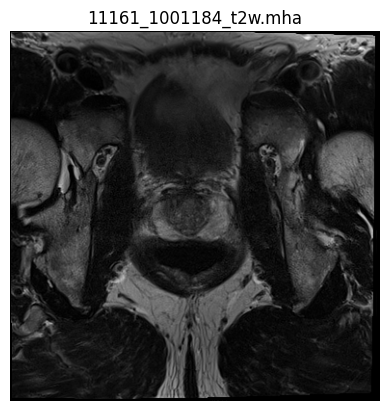

In [3]:
import random

# pick a random folder and set the name of a file inside as the prefix
d = "picai_folds/picai_images_fold0"
dirs = list(analyzer.get_dirs(d))
random_dir = random.choice(dirs)
files_in_dir = analyzer.get_files(join(d, random_dir), ".*_t2w.mha$")

name = list(files_in_dir)[0] # we have to do this because get files is a generator
f = join(d, random_dir, name)
analyzer.show_image(f)


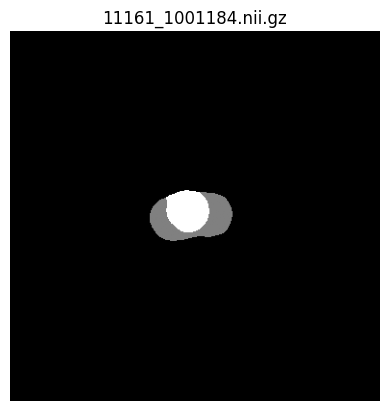

In [4]:
nii = name.split("_t2w")[0] + ".nii.gz"
f = join(paths['picai_labels_zonal'], nii)
analyzer.show_image(f)

Let's look for possible empty masks, since some of the lesion data was missing

In [5]:
# non_empty_count, empty_masks = analyzer.count_and_find_non_empty_masks(paths['picai_labels_zonal'])
# print(f"{non_empty_count} out of {non_empty_count+len(empty_masks)} masks are non-empty (contain a segmentation).")
# print("Empty mask files:", empty_masks)

Now, we use the function the analyzer to analyze the metadata.

In [6]:
# use this regex to filter the files
analyzer.regex = "(.*_t2w.mha$)|(.*_sag.mha$)|(.*_cor.mha$)"
res = analyzer.collect_metadata_to_dataframe("picai_folds/picai_images_fold0/10189")
print(res)

start = perf_counter()
df = analyzer.collect_metadata_from_subdirs("picai_folds/picai_images_fold0")
print(df)
print(perf_counter() - start, "seconds")

                filename orientation        dim_size  prostate_volume  \
0  10189_1000192_cor.mha         RSA  (320, 320, 19)            125.0   
1  10189_1000192_t2w.mha         RAI  (640, 640, 21)            125.0   
2  10189_1000192_sag.mha         ASL  (320, 320, 21)            125.0   

    vendor    mri_name  psa_report  
0  SIEMENS  Prisma_fit        5.97  
1  SIEMENS  Prisma_fit        5.97  
2  SIEMENS  Prisma_fit        5.97  


                  filename orientation        dim_size  prostate_volume  \
0    10961_1000980_t2w.mha         RAI  (384, 384, 21)            102.0   
1    10961_1000980_sag.mha         ASL  (320, 320, 19)            102.0   
2    10961_1000980_cor.mha         RSA  (320, 320, 17)            102.0   
3    10851_1000867_t2w.mha         RAI  (384, 384, 21)             89.0   
4    10851_1000867_sag.mha         ASL  (320, 320, 19)             89.0   
..                     ...         ...             ...              ...   
895  11045_1001065_cor.mha         RSA  (320, 320, 21)             32.0   
896  11045_1001065_sag.mha         ASL  (320, 320, 19)             32.0   
897  11153_1001176_sag.mha         ASL  (320, 320, 19)             16.8   
898  11153_1001176_t2w.mha         RAI  (384, 384, 21)             16.8   
899  11153_1001176_cor.mha         RSA  (320, 320, 21)             16.8   

      vendor mri_name  psa_report  
0    SIEMENS    Skyra        22.0  
1    SIEMENS    Skyra      

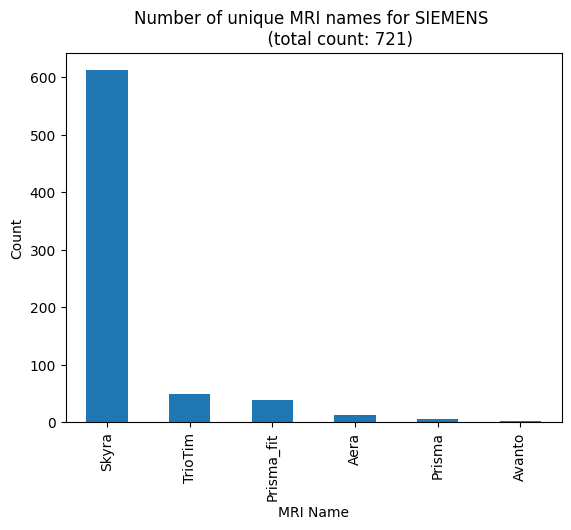

In [7]:
# for all the rows with vendor SIEMENS, get number of unique mri_names
siemens_mri_names = df[df['vendor'] == 'SIEMENS']['mri_name'].value_counts()

import matplotlib.pyplot as plt
siemens_mri_names.plot(kind='bar')
plt.title("""Number of unique MRI names for SIEMENS 
          (total count: {})""".format(siemens_mri_names.sum()))
plt.xlabel("MRI Name")
plt.ylabel("Count")
plt.show()

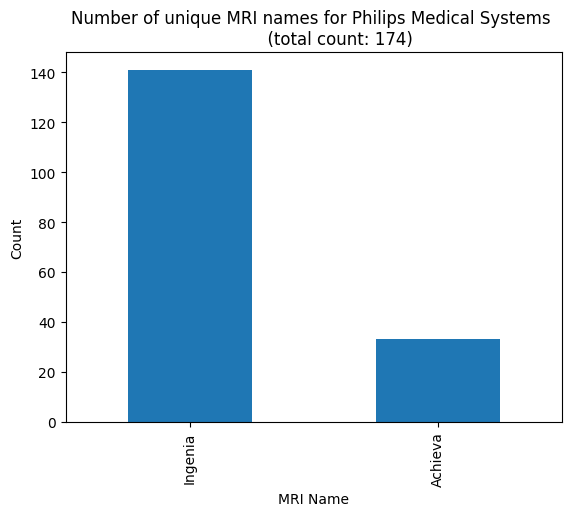

In [8]:
# for all the rows with vendor Philips Medical Systems, get number of unique mri_names
phl_mri_names = df[df['vendor'] == 'Philips Medical Systems']['mri_name'].value_counts()

# plot in a bar graph
import matplotlib.pyplot as plt
phl_mri_names.plot(kind='bar')
plt.title("""Number of unique MRI names for Philips Medical Systems 
          (total count: {})""".format(phl_mri_names.sum()))
plt.xlabel("MRI Name")
plt.ylabel("Count")
plt.show()

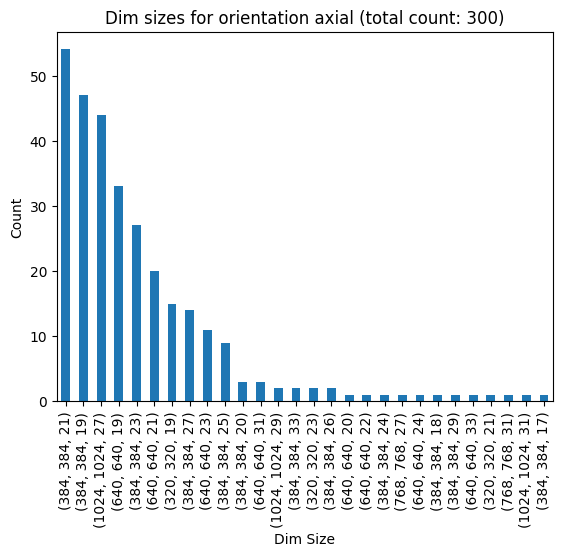

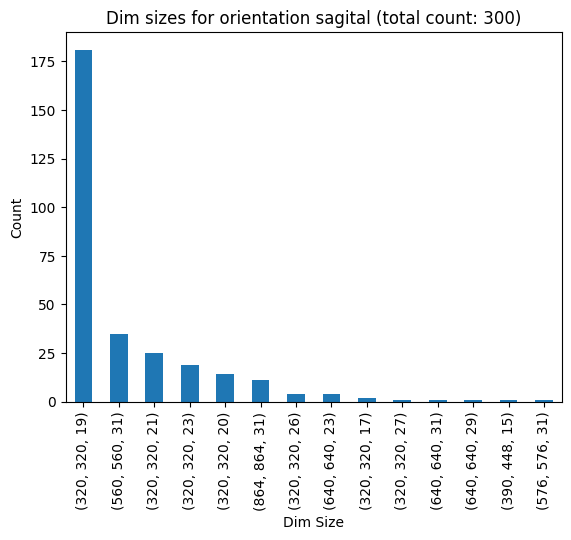

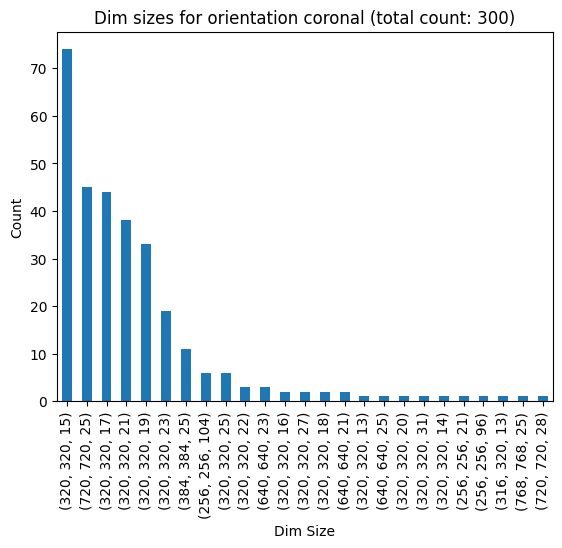

In [9]:
orientations = {"RAI" : "axial", "ASL" : "sagital", "RSA" : "coronal"}

for orientation, value in orientations.items():
    orientation_df = df[df['orientation'] == orientation]
    # get the dim_size for each orientation and plot it
    dim_sizes = orientation_df['dim_size'].value_counts()

    dim_sizes.plot(kind='bar')
    plt.title(f"Dim sizes for orientation {value} (total count: {dim_sizes.sum()})")
    plt.xlabel("Dim Size")
    plt.ylabel("Count")
    plt.show()